In [1]:
!pwd

/Users/ashish1610dhiman/data_projects/fall22_hw/RoboChef/notebooks/recommendation


In [2]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

### Steps
1. Preprocess data into a matrix of Users x Recipees with entries as ratings
2. Apply Matrix Factorisation and train a vanilla reccomedation

In [3]:
raw_interactions = pd.read_csv("../../data/recommendation/RAW_interactions.csv")
raw_interactions.shape

(1132367, 5)

In [4]:
raw_interactions[["user_id","recipe_id"]].nunique()

user_id      226570
recipe_id    231637
dtype: int64

In [35]:
N_users = 226570
N_Recipes = 231637

In [5]:
raw_interactions.head(5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


### Estimated Sparsity

In [6]:
raw_interactions[["user_id","recipe_id"]].nunique()

user_id      226570
recipe_id    231637
dtype: int64

In [7]:
sum(raw_interactions["rating"].isna())

0

In [8]:
raw_interactions[["user_id","recipe_id"]].drop_duplicates().count()

user_id      1132367
recipe_id    1132367
dtype: int64

In [36]:
sparsity = 1- (1132367/(N_users*N_Recipes))
print (f"Sparsity in data {sparsity:.9%}")

Sparsity in data 99.997842371%


### Filter for active users first, where active measured basis number of dishes rated

In [10]:
raw_interactions["date1"]=pd.to_datetime(raw_interactions["date"])

user_grp = raw_interactions.groupby("user_id").agg({"recipe_id":"count",\
                                                   "rating":"mean",\
                                                   "date1":["max","min"]})
user_grp.head()

recipe_id    rating      date1           
            count      mean        max        min
user_id                                          
1533          128  4.710938 2008-03-01 2002-02-19
1535          794  4.473552 2018-03-03 2004-05-22
1581            1  5.000000 2013-11-11 2013-11-11
1634           60  3.616667 2011-03-09 2001-07-02
1676           31  4.677419 2014-07-09 2002-07-24

<AxesSubplot: >

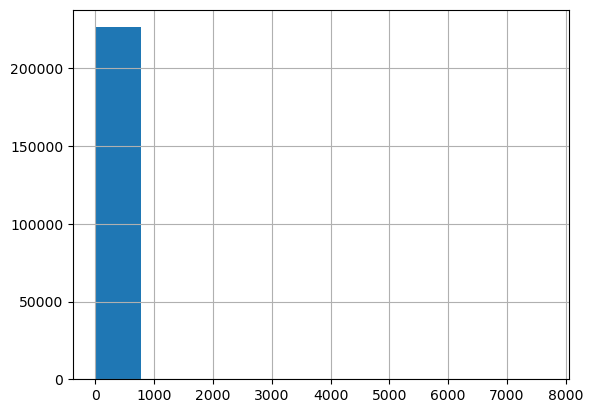

In [11]:
user_grp[("recipe_id","count")].hist()

In [12]:
user_grp[("recipe_id","count")].dtype

dtype('int64')

In [13]:
user_grp[[("recipe_id","count")]].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

,recipe_id
,count
0.1,1.0
0.2,1.0
0.3,1.0
0.4,1.0
0.5,1.0
0.6,1.0
0.7,1.0
0.8,2.0
0.9,5.0


In [37]:
active_users = user_grp[("recipe_id","count")] >= 2
n_active_users = sum(active_users)
print (f"users remianing= {n_active_users},%users remaining = {n_active_users/N_users:.3%}")

user_grp_active = user_grp[active_users]
user_grp_active.columns = ["recipe_cnt","rating_mean","date1_max","date1_min"]

active_user_interactions = user_grp_active.merge(raw_interactions,\
                                                  left_index = True, right_on = "user_id")
active_user_interactions[["user_id","recipe_id"]].nunique()

users remianing= 60314,%users remaining = 26.620%


user_id       60314
recipe_id    219357
dtype: int64

In [39]:
n_recipes = 219357
print (f"%recipee coverage = {n_recipes/N_Recipes:.3%}")

%recipee coverage = 94.699%


In [16]:
active_user_interactions[["user_id","recipe_id"]].drop_duplicates().count()

user_id      966111
recipe_id    966111
dtype: int64

In [17]:
sparsity1 = 1- (966111/(60314*219357))
print (f"Sparsity in active user data {sparsity1:.9%}")

Sparsity in active user data 99.992697738%


### Further subset active recipees, where active defined by the most recent rating in a given threshold of time

In [18]:
recipe_grp = active_user_interactions.groupby("recipe_id").agg({"user_id":"count",\
                                                   "rating":"mean",\
                                                   "date1":["max","min"]})
recipe_grp.head()

user_id    rating      date1           
            count      mean        max        min
recipe_id                                        
38              3  4.333333 2014-08-14 2008-02-13
39              1  3.000000 2007-01-20 2007-01-20
40              7  4.142857 2010-05-23 2002-12-18
41              2  4.500000 2009-01-26 2003-04-13
43              1  1.000000 2009-02-07 2009-02-07

In [32]:
days_since = pd.to_datetime('today') - recipe_grp[("date1","max")]
recipe_grp["yrs_since_today"] = days_since.apply(lambda x: x.days/365)

<AxesSubplot: >

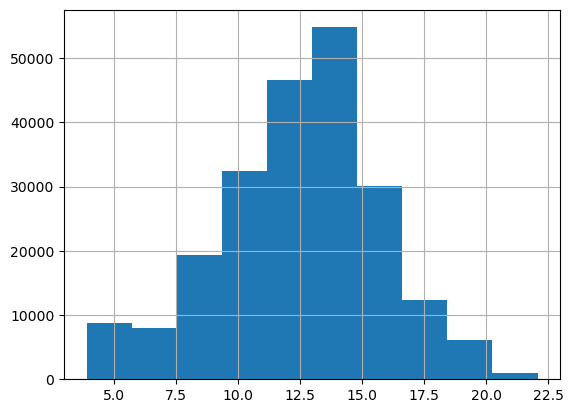

In [33]:
recipe_grp["yrs_since_today"].hist()

In [34]:
recipe_grp["yrs_since_today"].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

0.1     8.271233
0.2     9.810959
0.3    11.043836
0.4    12.024658
0.5    12.810959
0.6    13.482192
0.7    14.169863
0.8    15.021918
0.9    16.342466
1.0    22.060274
Name: yrs_since_today, dtype: float64

In [45]:
active_recipes = recipe_grp["yrs_since_today"] <= 12
n_active_recipes = sum(active_recipes)
print (f"recipes remianing= {n_active_recipes},%recipees remaining = {n_active_recipes/N_Recipes:.3%}")

recipe_grp_active = recipe_grp[active_recipes][["yrs_since_today"]]
recipe_grp_active.columns = ["yrs_since_today"]

active_user_recipe_interactions = recipe_grp_active.merge(active_user_interactions,\
                                                  left_index = True, right_on = "recipe_id")
active_user_recipe_interactions[["user_id","recipe_id"]].nunique()

recipes remianing= 87319,%recipees remaining = 37.696%


user_id      57304
recipe_id    87319
dtype: int64

In [47]:
n_users1 = 57304
print (f"%User coverage = {n_users1/N_users:.3%}")

%User coverage = 25.292%


### Build User Rating Matrix on the active user list

In [49]:
# rating_matrix = pd.pivot_table(active_user_recipe_interactions,index=["user_id"],\
#                               columns=["recipe_id"],values=["rating"])